Imports


In [1]:
from pathlib import Path
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd().parent  # notebooks/ -> project root
DB_PATH = PROJECT_ROOT / "data_processed" / "pap.db"
DB_PATH.exists(), DB_PATH


(True,
 WindowsPath('d:/Preuzimanja/PZAP_PROJEKT/PAP_PROJEKT/data_processed/pap.db'))

Helper za čitanje tablica

In [2]:
def read_table(name: str) -> pd.DataFrame:
    conn = sqlite3.connect(DB_PATH)
    try:
        return pd.read_sql_query(f"SELECT * FROM {name};", conn)
    finally:
        conn.close()

dt_yearly = read_table("dt_yearly")
wb_year = read_table("wb_internet_year")
ind = read_table("integrated_individual")

dt_yearly.head(), wb_year.head(), ind.head()


(   Year  daily_minutes  internet_pct
 0  2012             90     38.020353
 1  2013             95     40.499988
 2  2014            104     43.315020
 3  2015            111     46.123280
 4  2016            128     49.483999,
    Year  internet_pct
 0  1960           NaN
 1  1961           NaN
 2  1962           NaN
 3  1963           NaN
 4  1964           NaN,
    age  gender    job_type  daily_social_media_time  number_of_notifications  \
 0   56    Male  Unemployed                 4.180940                       61   
 1   46    Male      Health                 3.249603                       59   
 2   56  Female  Unemployed                 4.381070                       60   
 3   36  Female   Education                 4.089168                       49   
 4   40  Female   Education                 4.097401                       57   
 
    work_hours_per_day  perceived_productivity_score  \
 0            6.753558                      8.040464   
 1            9.169296          

Brzi pregled podataka

In [4]:
def quick_overview(df: pd.DataFrame, name: str):
    print(f"=== {name} ===")
    print("shape:", df.shape)
    print("missing ratio (top 10):")
    miss = (df.isna().mean().sort_values(ascending=False) * 100).head(10)
    display(miss.to_frame("missing_%"))
    print()

quick_overview(dt_yearly, "dt_yearly")
quick_overview(wb_year, "wb_internet_year")
quick_overview(ind, "integrated_individual")


=== dt_yearly ===
shape: (13, 3)
missing ratio (top 10):


,missing_%
Year,0.0
daily_minutes,0.0
internet_pct,0.0



=== wb_internet_year ===
shape: (65, 2)
missing ratio (top 10):


,missing_%
internet_pct,46.153846
Year,0.000000



=== integrated_individual ===
shape: (23730, 15)
missing ratio (top 10):


,missing_%
stress_level,6.316898
gender,0.000000
age,0.000000
daily_social_media_time,0.000000
number_of_notifications,0.000000
work_hours_per_day,0.000000
job_type,0.000000
perceived_productivity_score,0.000000
actual_productivity_score,0.000000
social_platform_preference,0.000000


Graf 1: DT trend po godinama

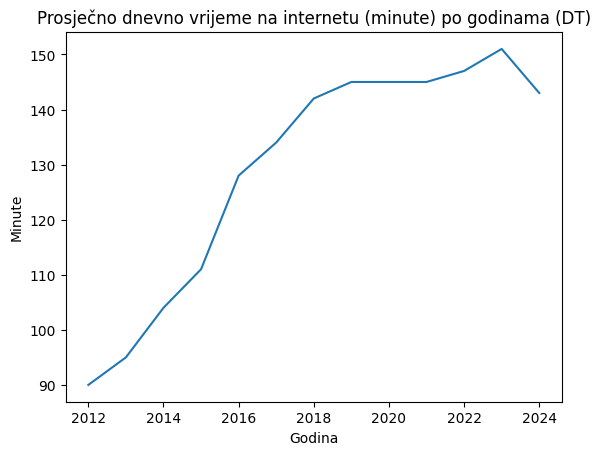

In [5]:
dt_yearly = dt_yearly.sort_values("Year")
plt.figure()
plt.plot(dt_yearly["Year"], dt_yearly["daily_minutes"])
plt.title("Prosječno dnevno vrijeme na internetu (minute) po godinama (DT)")
plt.xlabel("Godina")
plt.ylabel("Minute")
plt.show()


Graf 2: WorldBank trend (internet_pct)

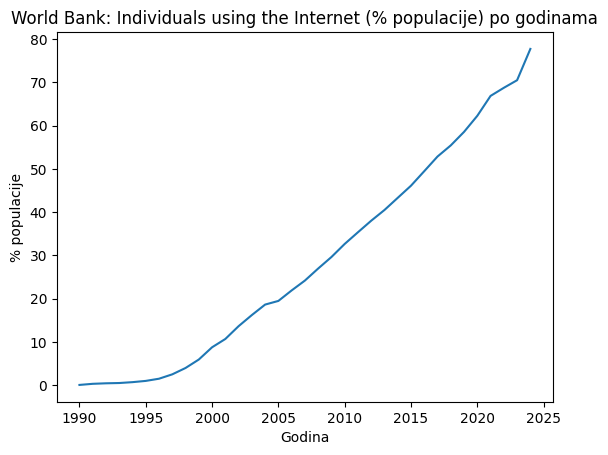

In [6]:
wb_year = wb_year.sort_values("Year")
plt.figure()
plt.plot(wb_year["Year"], wb_year["internet_pct"])
plt.title("World Bank: Individuals using the Internet (% populacije) po godinama")
plt.xlabel("Godina")
plt.ylabel("% populacije")
plt.show()
